# Lab 1: Demosicing and Color Correction

In this lab we will explore and implement some of the most common processes that are applied to images from raw to JPG or other formats. We will also use this to get familiar with some simple image processing in Python.

We will use scipy.ndimage to load and save images which has a simple interface and stores the data as simple numpy arrays. 

You are free to edit the code however you please.


Populating the interactive namespace from numpy and matplotlib


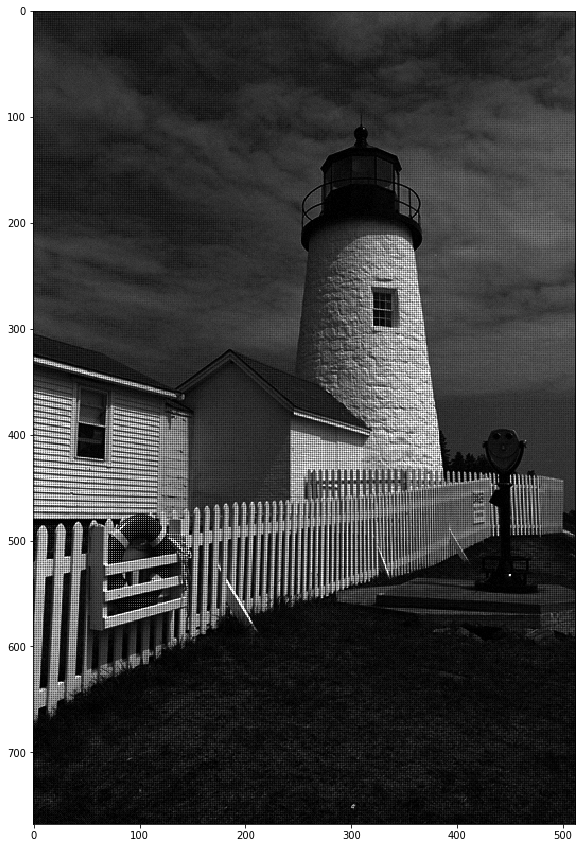

In [1]:
#some magicto show the images inside the notebook
%pylab inline
%matplotlib inline

import matplotlib.pyplot as plt
from scipy import ndimage
import numpy as np
from scipy import signal

# A hepler function for displaying images within the notebook.
# It displays an image, optionally applies zoom the image.
def show_image(img, zoom=1.5):
    dpi = 77
    plt.figure(figsize=(img.shape[0]*zoom/dpi,img.shape[0]*zoom/dpi))
    if len(img.shape) == 2:
        img = np.repeat(img[:,:,np.newaxis],3,2)        
    plt.imshow(img, interpolation='nearest')
    

# A hepler function for displaying images within the notebook.
# It may display multiple images side by side, optionally apply gamma transform, and zoom the image.
def show_images(imglist, zoom=1, needs_encoding=False):
    if type(imglist) is not list:
       imglist = [imglist]
    n = len(imglist)
    first_img = imglist[0]
    dpi = 77 # pyplot default?
    plt.figure(figsize=(first_img.shape[0]*zoom*n/dpi,first_img.shape[0]*zoom*n/dpi))
    for i in range(0,n):
        img = imglist[i]
        plt.subplot(1,n,i + 1)
        plt.tight_layout()    
        plt.axis('off')
        if len(img.shape) == 2:
           img = np.repeat(img[:,:,np.newaxis],3,2)
        plt.imshow(img, interpolation='nearest')    
    
lighthouse = "data/lighthouse_RAW_noisy_sigma0.01.png"
img=ndimage.imread(lighthouse)

#show_image(img[200:400,200:400],3) #takes a region of the image 
show_image(img)
#print(img)

## Task 1: DCRAW (10)

The first task is to get familiar with the tool DCRAW. www.cybercom.net/~dcoffin/dcraw/. You are given an image _MG_4257.CR2 which is the RAW format for Canon DSLR cameras. Install it in your computer and run it, you will get the options and usage. In this task you should define some functions that simply call the dcraw command with the appropriate options from the a python programm

### Convert to JPG from RAW

Convert to a normal jpg in sRGB color space. Test different options and compare the results. 

### Extract RAW data

Identify the option for this and recover the original raw data in a standard image format (pgm). This will be a black and white image with a bayer pattern.

### Convert to Linear tiff 16 bits 

The standard pipeline applies color and gamma corrections, when we use images for computation is best to have the linear input and preserve as much information as possible. Find the options to recover the linear 16 bits tiff image from the raw.

### If you have a camera, do the same with your own images
Capture an image with your camera in RAW mode, extract the RAW image using the command line software
dcraw (don’t process the image, just extract the linear, RAW), 


In the next tasks test your code for demosaicking and gamma correction on your own raw images, compare with the results you get from dcraw (for demosaicking and conversion to sRGB). If you can’t capture, you have an example in data.

In [2]:
###HINT: Look for the "subprocess" module
from subprocess import *
import os
import sys

def opentemp(name="temp",mode='r+b'):
    f=open(name,'w')
    f.close()
    f=open(name,mode)
    return f

def raw2something(path_to_file,output_name,converter_opt=[],dcraw_opt=[]):
    wyn=0
    temppict=output_name
    if "win" in sys.platform:
        try:
            buffor="temp"
            if not converter_opt:
                converter_opt=["magick", buffor,temppict]
            if not dcraw_opt:
                dcraw_opt=["dcraw","-c",path_to_file]
            buffor="temp"
            f=opentemp(buffor,'r+b')
            p1 = Popen(dcraw_opt, stdout=f)
            retcode=p1.wait()
            f.flush()
            p2 = Popen(converter_opt, stdin=f, stdout=PIPE)
            retcode=p2.wait()
            wyn=ndimage.imread(temppict)
            print(f.close())
            os.remove(buffor)
            #os.remove(temppict)
        except OSError as e:
            print(e)
    else:
        try:
            if not converter_opt:
                converter_opt=["magick","fd:0",temppict]
            if not dcraw_opt:
                dcraw_opt=["dcraw","-c",path_to_file]
            p1 = Popen(dcraw_opt, stdout=PIPE)
            p2 = Popen(converter_opt, stdin=p1.stdout, stdout=PIPE)
            retcode=p2.wait()
            wyn=ndimage.imread(temppict)
            f.close()
            os.remove(temppict)
        except OSError as e:
            print(e)
    return wyn

def raw2JPG(path_to_file):
    if "win" in sys.platform:
        return raw2something(path_to_file,"temp.jpg")
    else:
        return raw2something(path_to_file,"temp.jpg",["cjpeg", "-outfile temp.jpg"])

def extract_raw(path_to_file):
    return raw2something(path_to_file,"temp.pgm")

def raw2linear_tiff(path_to_file):
    return raw2something(path_to_file,"temp.tiff",dcraw_opt=["dcraw","-T","-6","-d","-c",path_to_file])

#show_image(raw2JPG("./data/raw/_MG_4257.CR2"))
#show_image(raw2linear_tiff("./data/raw/_MG_4257.CR2"))
#show_image(extract_raw("./data/raw/_MG_4257.CR2"))
image=ndimage.imread("inny.tiff")
#print(np.shape(image[2000:,3000:]))
#show_image((2**16-1)-image[2000:,:1000])
#load the converted images and display using show_images()

IOError: [Errno 2] No such file or directory: 'inny.tiff'

In [ ]:
#tiff is inverted on windows for some reason
image=ndimage.imread("inny.tiff")
show_image(np.maximum(np.ones(np.shape(image)),(2**16-1)-image))
test_image=np.maximum(np.ones(np.shape(image)),(2**16-1)-image)
tests=[img,test_image]


## Task 2: Gamma Correction(10)

Take the 16 bits linear image and apply a gamma encoding to it. https://en.wikipedia.org/wiki/Gamma_correction

Display the linear image, the gamma encoded one, and the JPG produce by dcraw.


In [ ]:
# Verbose aliases for gamma transformation
def gamma_decode(img, gamma=2.2):
    #Input is a gamma encoded image, output is a linear image
    scaling=np.power(img.astype(float),np.ones(img.shape)/gamma)
    normalizing=scaling / np.linalg.norm(scaling)
    return normalizing*np.iinfo(img.dtype).max

def gamma_encode(img, gamma=2.2):
    #Input is a linear image, output is a gamma encoded image 
    scaling=np.power(img.astype(float),np.ones(img.shape)*gamma)
    normalizing=scaling / np.linalg.norm(scaling)
    return normalizing*np.iinfo(img.dtype).max

test_encode=gamma_encode(tests[0])
test_decode=gamma_decode(tests[0])
show_images([test_encode,test_decode])
#load the converted images and display using show_images()

## Task 3: White Balance (10)

White balance is the process of setting whites to white. Depending on the lighting, white pixels will look of the colour of the light, in our example whites look quite yellowish. https://en.wikipedia.org/wiki/Color_balance

Different methods exist to estimate the color of the light, you will implement two simple white balance methods. 

The white point simple takes in a pixel (three values) which we know is white, for example a pixel from the fence, and use this pixel to set it to white, and the rest of the image accordingly.

The second method is the "grey world assumtion". The idea here is to compensate the color channels so their average is grey (all channels have the same value). To do this, compute the mean of each channel (RGB), normalize to the maximum value of the triplet, and use this as your compensation factor.  




In [ ]:
def white_balance_white_point(img, whitePoint):
    #your code here    
    #HINT: You will probably need to use np.clip
    img=img/whitePoint
    
    return np.clip(img,0.,1.) #!change accordingly


def white_balance_gray(img):
    #your code here    
    #HINT: You will probably need to use reshape
    av=np.average(np.average(img, axis=0), axis=0)
    maxa=np.amax(np.amax(img, axis=0),axis=0)
    alfa=maxa/(2*av)
    img=img*alfa
    return np.clip(img,0.,1.) #!change accordingly


im = ndimage.imread("data/lighthouse.png")/255.0
#print(im)

im_wp = white_balance_white_point(im,im[309:310,348:349,:].flatten()) #you can select a different pixel

im_g = white_balance_gray(im)

show_images([im,im_wp,im_g],0.5)


In [ ]:
#White balance other images and display using show_images()

## Task 4: Basic Demosaicing (20) 
Implement demosaicking using linear interpolation. The example image
‘lighthouse_RAW_colorcoded.png’ shows you in false colors which subpixel measures with color
channel. Don’t use that for demosaicking, use the image ‘lighthouse_RAW_noisy_sigma0.01.png’
Check your implementation with other images from data/raw. Lecture 2 slides here
http://franchomelendez.com/Uwr/teaching/COMPHO/_LECTURES/L2/digital_photography.html


Unfortunatelly, not all the sensors have the same pattern, so you will find that the patern for lighthouse image is not valid for the other raw images. In essence in these cases the result is that the blue and red channels are exchanged. You can ignore this for the naive solution and hardcode the pattern, but you should take it into account when developing the other solutions.


In [ ]:
# A helper function for merging three single-channel images into an RGB image
def combine_channels(ch1, ch2, ch3):
    return np.dstack((ch1, ch2, ch3))

def demosaic_simple_naive_rgb(img):
    s=img.shape
    img=img.astype(uint16)
    red=img*1
    blue=img*1
    green=img*1
    for i in range(s[0]):
        for j in range(s[1]):
            im1,ip1,jm1,jp1=(max(0,i-1),min(i+1,s[0]-1),max(0,j-1),min(j+1,s[1]-1))
            if(i%2==0 and j%2==0):
                red[i,j]=img[i,j]
                blue[i,j]=(img[im1,jm1]+img[ip1,jm1]+img[ip1,jp1]+img[im1,jp1])/4
                green[i,j]=(img[im1,j]+img[ip1,j]+img[i,jm1]+img[i,jp1])/4
            elif(i%2==1 and j%2==1):
                blue[i,j]=img[i,j]
                red[i,j]=(img[im1,jm1]+img[ip1,jm1]+img[ip1,jp1]+img[im1,jp1])/4
                green[i,j]=(img[im1,j]+img[ip1,j]+img[i,jm1]+img[i,jp1])/4
            else:
                green[i,j]=img[i,j]
                if(i%2==0):
                    red[i,j]=(img[i,jm1]+img[i,jp1])/2
                    blue[i,j]=(img[im1,j]+img[ip1,j])/2
                else:
                    blue[i,j]=(img[i,jm1]+img[i,jp1])/2
                    red[i,j]=(img[im1,j]+img[ip1,j])/2
    return (red,green,blue)

def demosaic_simple_naive(img):
    red,green,blue=demosaic_simple_naive_rgb(img)
    kek=np.ones(img.shape)
    return combine_channels(red,green,blue).astype(uint8)

tests.append(tests[0][:40,:40])
show_image(demosaic_simple_naive(tests[0])) #should show a color image

### Tiles, masks, convolve.

So far you didn't need to think too much, this should be a bit more challenging. Some things that might be useful are numpy.tiles which replicates a pattern a given number of times. 

You can use this for example to specify mask, which you can simply multiply by the image to get a masked image. Masks should have only values of 0 or 1. 

Convolutions are an important concept in image processing. You have a visual explanation here http://setosa.io/ev/image-kernels/ convolutions are expensive operations, specially when the kernels get big. Fortunatelly ndimage provides us with implementations that work like this: 

```python
kernel = np.array([[1,0,1],[0,0,0],[1,0,1]])
#This kernel only uses the corner pixels

gradient = ndimage.convolve(image, kernel)/4 
#In order to normalize the value of the pixel, we need to divide by the sum of the values in the kernel

#This would be equivalent to:
kernel = np.array([[0.25,0,0.25],[0,0,0],[0.25,0,0.25]])
gradient = ndimage.convolve(image, kernel) 

```
You can use convolutions to compute the gradient in the next task as well. 


In [ ]:
patterns_bayer='RGGB'


def recognize_pattern(pattern,shape):
    s=shape
    i1,i2,i3,i4=(0,0,1,1)
    if pattern=='BGGR':
        i1,i2,i3,i4=(1,1,0,0)
    elif pattern=='GBRG':
        i1,i2,i3,i4=(1,0,0,1)
    elif pattern=='GRBG':
        i1,i2,i3,i4=(0,1,1,0)
    v1=np.array([int(x%2==i1) for x in range(s[0])]).reshape(-1,1)
    v1t=np.array([int(x%2==i2) for x in range(s[1])]).reshape(1,-1)
    v2=np.array([int(x%2==i3) for x in range(s[0])]).reshape(-1,1)
    v2t=np.array([int(x%2==i4) for x in range(s[1])]).reshape(1,-1)
    #print(v1,v1t,v2,v2t)
    red=v1*v1t
    blue=v2*v2t
    green=(np.ones(s)-red-blue).astype(uint8)
    return red,green,blue
        

def demosaic_simple_rgb(img,pattern='RGGB'):  
    typ=img.dtype
    s=img.shape
    kek=np.ones(s)
    v1m,gp,v2m=recognize_pattern(pattern,s)
    #print(v1,v1t,v2,v2t)
    #brdpatt=v1m+v2m
    #gpatt=np.ones(s)-brdpatt
    blue=img*v2m
    red=v1m*img
    green=gp*img
    kernelrb=np.array([[0.25,0.5,0.25],[0.5,1.0,0.5],[0.25,0.5,0.25]])
    kernelg=np.array([[0,0.25,0],[0.25,1.0,0.25],[0,0.25,0]])
    red2=ndimage.convolve(red,kernelrb).astype(typ)
    green2=ndimage.convolve(green,kernelg).astype(typ)
    blue2=ndimage.convolve(blue,kernelrb).astype(typ)
    return (red2,green2,blue2)
    
    
def demosaic_simple(img,pattern='RGGB'):     
### Reimplement simple demosaicing without using loops
    red,green,blue=demosaic_simple_rgb(img,pattern)
    return combine_channels(red,green,blue) #!change accordingly

kek=demosaic_simple(tests[0])
print(kek.dtype)
show_image(white_balance_gray(demosaic_simple(tests[0])/255.0))

## Task 5: Edge-based Demosaicing (25 pts)

Implement Edge-based Demosaicing. Compare the results. Details are in the lecture notes.

For the green channel use this recipe:
Summary: ![Alt](./demosaicing-edge-green.png "Title")


For the other two channels use green based interpolation (example for the red channel): 

1. For recorded red pixels compute R-G
2. At empty pixels Interpolate R-G naively
3. Add G

Do the same for blue

In [2]:
tests.append(tests[0][500:518,400:418])
def demosaic_stest(img,pattern='RGGB'):
    s=img.shape
    o=np.ones(s)
    r,g,b=demosaic_simple_rgb(img,pattern)
    #return r
    return combine_channels(r,g,b)

def demosaic_green_edge_based(img, patterns=patterns_bayer, offset=(0,0)):
### Implement the green edge based demosaicing algorithm 
    typ=img.dtype
    s=img.shape
    
    rp,gp,bp=recognize_pattern(patterns,s)
    greenbase=img*gp
    greenh=abs(ndimage.convolve(greenbase.astype(int),[[1,0,-1]])).astype(typ)
    greenv=abs(ndimage.convolve(greenbase.astype(int),[[1],[0],[-1]])).astype(typ)
    gbool=greenh>greenv
    gbool2=greenh<greenv
    gbool3=greenh==greenv
    
    
    green=ndimage.convolve(greenbase,[[0, 0, 0],[0.5, 1.0, 0.5],[0, 0, 0]])*gbool2#*(rp+bp)
    green=green+ndimage.convolve(greenbase,[[0, 0.5, 0],[0, 1.0, 0],[0, 0.5, 0]])*(gbool)#*(rp+bp)
    green=green+ndimage.convolve(greenbase,[[0, 0.25, 0],[0.25, 1.0, 0.25],[0, 0.25, 0]])*(gbool3)#*(rp+bp)
    #print(green.astype(int)-greenbase)
    green=green.astype(typ)
    red=((img).astype(int)-green)*rp
    blue=((img).astype(int)-green)*bp
    
    kernelrb=np.array([[0.25,0.5,0.25],[0.5,1.0,0.5],[0.25,0.5,0.25]])
    #print(ndimage.convolve(red,kernelrb),red)
    red=np.clip((ndimage.convolve(red,kernelrb)+green),0,np.iinfo(img.dtype).max).astype(typ)
    blue=np.clip((ndimage.convolve(blue,kernelrb)+green),0,np.iinfo(img.dtype).max).astype(typ)

    return combine_channels(red,green,blue) #!change accordingly


lh_basic = demosaic_stest(tests[0])
lh_gb = demosaic_green_edge_based(tests[0])
#show_image(lh_gb,zoom=10)
#this should show the images demosaiced
show_images([lh_basic[450:550, 50:150],
            lh_gb[450:550, 50:150]], zoom=3.5, needs_encoding=True)

NameError: name 'tests' is not defined

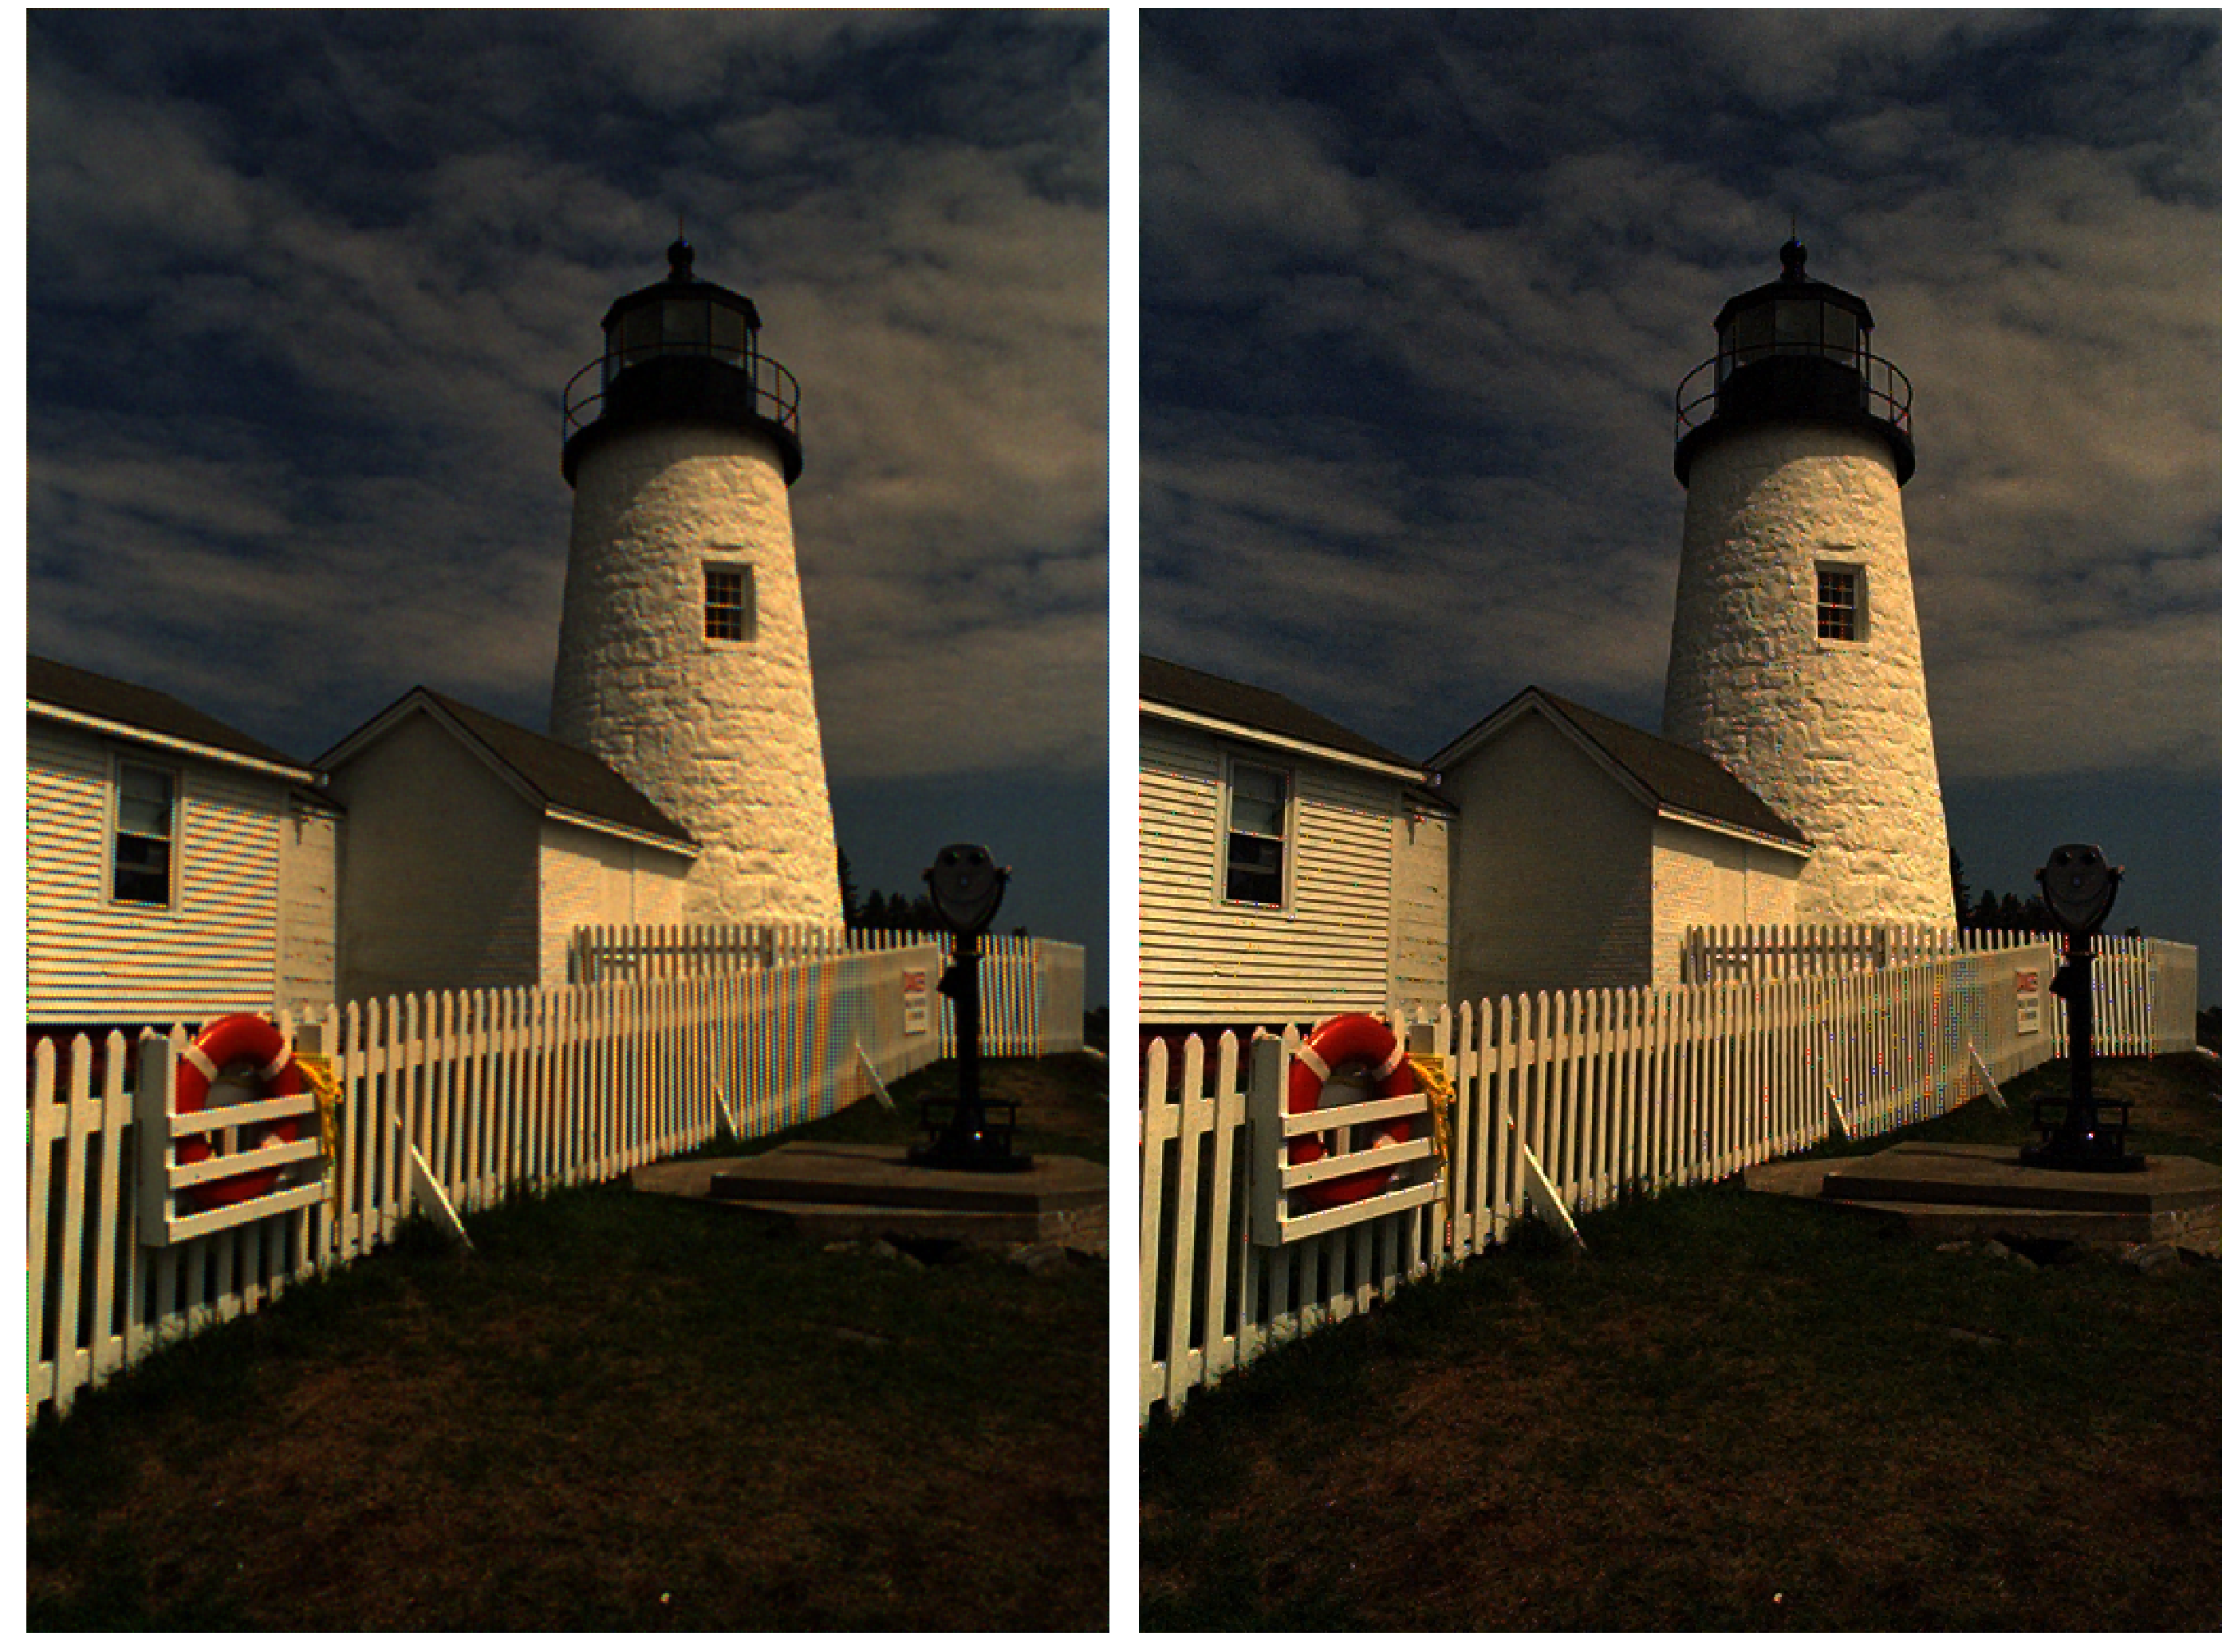

In [288]:
show_images([lh_basic, lh_gb], zoom=2, needs_encoding=True) 

## Task 6: Filter the chromacity (25)

Unfortunately, the lighthouse is a difficult example for demosaicking. You should see color artifacts
in the fence. Go back to the linear demosaicked image, convert it to YCrCb color space and
median filter the chrominance channels but not the luminance channel. Convert back to RGB and
then apply the sRGB gamma. You can use the implementation of the median filter available in ndimage, but you need to understand how it works and how you could implement a simple version.

You can find the coefficients in JPEG specification (https://www.w3.org/Graphics/JPEG/jfif3.pdf).

### NOTE: 
The YCbCr color space convertion needs to add a constant (128 or 0.5) to avoid negative values, since image formats don't allow for negative values. However, in our case, we don't care if we have negative values in our represntation (since they are floats) and because we are converting back to RGB. So you can safely ignore those constants for this task, which simplifies the convertion to a dot product. 


[[[ 17.089   -5.6931   7.0691]
  [ 29.132   -7.9756  -4.374 ]]

 [[ 28.833   -7.8069  -4.874 ]
  [ 23.868    4.0244  -6.3252]]]
[[[ -5.6931   7.0691  17.089 ]
  [ -7.9756  -4.374   29.132 ]]

 [[ -7.8069  -4.874   28.833 ]
  [  4.0244  -6.3252  23.868 ]]]


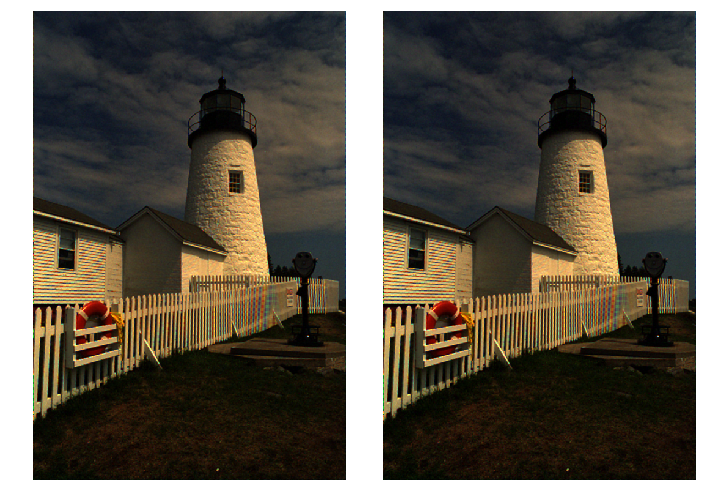

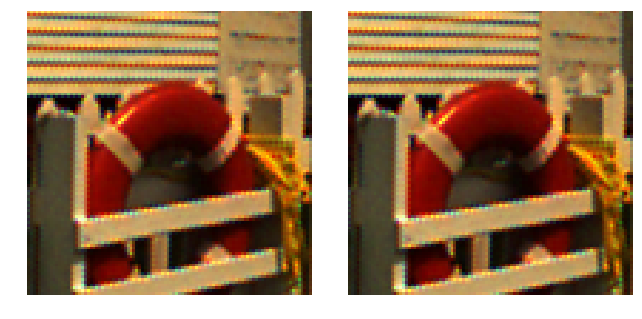

In [320]:
import scipy
# Functions for converting color space on a three-channel image between RGB and YCbCr.
#Y = 0.299 R + 0.587 G + 0.114 B
#Cb = - 0.1687 R - 0.3313 G + 0.5 B 
#Cr = 0.5 R - 0.4187 G - 0.0813 B
#R = Y + 1.402 (Cr)
#G = Y - 0.34414 (Cb) - 0.71414 (Cr)
#B = Y + 1.772 (Cb)
def rgb2ycbcr3(dtuple):
    R,G,B=dtuple
    Y = 0.299* R + 0.587 *G + 0.114 *B
    Cb = - 0.1687* R - 0.3313* G + 0.5 *B #+128
    Cr = 0.5* R - 0.4187 *G - 0.0813 *B#+128
    return [Cb,Cr,Y]

def ycbcr2rgb3(dtuple):
    Cb,Cr,Y=dtuple
    R = Y + 1.402 *(Cr)#-128)
    G = Y - 0.34414 *(Cb) - 0.71414 *(Cr)
    B = Y + 1.772 *(Cb)
    return [R,G,B]

def rgb2YCbCr(img):
    #print(img.shape)
    img2=img.dot(np.array([[0.299,0.587,0.114],[-0.1687,-0.3313,0.5],[0.5,-0.4187,-0.0813]]).T)
    print(img2[:2,:2])
    img=np.array([[rgb2ycbcr3(y) for y in x] for x in img])
    print(img[:2,:2])
    return img #!change accordingly
def YCbCr2rgb(img,typ):
    img=np.array([[ycbcr2rgb3(y) for y in x] for x in img]).astype(typ)
    return img #!change accordingly
# Median filter on 2nd and 3rd channels only
# def median_filter(img,size):
    
def median_chrominance(img):
    stuff=scipy.ndimage.filters.median_filter(img,size=3) #!change accordingly
    #img=np.dstack((stuff,img[:,:,2:]))
    return img
    
# This function applies a median chrominance filter on an RGB image
def filter_median_chrominance(img):
    img = rgb2YCbCr(img)
    img = median_chrominance(img)
    img = YCbCr2rgb(img,img.dtype)
    return img

lh_eb = demosaic_simple(img)
#print(lh_eb)
lh_filtered = filter_median_chrominance(lh_eb).astype(lh_eb.dtype)
show_images([lh_eb, lh_filtered], zoom=0.5, needs_encoding=True)
show_images([lh_eb[450:550, 50:150], lh_filtered[450:550, 50:150]], zoom=3.5, needs_encoding=True)

dtype('float64')

## Task 7: Test with other images

Test with other given images an display the results in a similar fashion to the upper ones using show_images().

You can also save the files using 

```python
imsave('image_file.png', img)
```